In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import *
from scipy.stats import norm

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

Load data into Pandas dataframe. To be implemented: run some tests to ensure data quality

- does run exist? 
- does run contain responses?
- does run log color_balance and fix_intensity values correctly?

## Creating analysis script to run with attn task

BLUE (> 0.5) = 'LEFT'; PINK (> 0.5) = 'RIGHT'

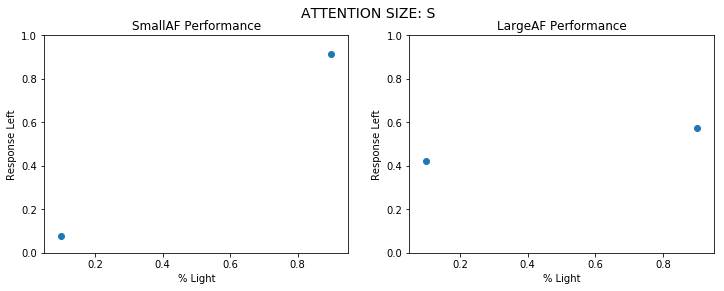

In [275]:
def analyse2afc(folder):
    wd = os.getcwd()
    f = glob.glob(f"{wd}/logs/{folder}/*.tsv")[0]

    sub,ses,task,run,_ = [i.split('-')[-1] for i in folder.split('_')]
    sz = task[-1]
    task=task[:-1]

    df = pd.read_table(f,keep_default_na=True)
    df = df[df.event_type == 'response']
    df.drop(['nr_frames','duration'],axis=1,inplace=True)
    df['attn_size']=sz
    df['corr_L'] = np.nan
    df['corr_S'] = np.nan

    cols = [['large_prop','small_prop'],['corr_L','corr_S']]
    summary = pd.DataFrame([])
    not_task = pd.DataFrame([])

    for prop,cor in zip(cols[0],cols[1]):
        true_left = df[(df[prop] > 0.5) & (df.response == 'left')].index
        false_left = df[(df[prop] < 0.5) & (df.response == 'left')].index
        true_right = df[(df[prop] < 0.5) & (df.response == 'right')].index
        false_right = df[(df[prop] > 0.5) & (df.response == 'right')].index

        df.loc[np.hstack((true_left,true_right)), cor] = 1
        df.loc[np.hstack((false_left,false_right)), cor] = 0
        df =  df.dropna(subset=[cor])

        diffs = sorted(df[prop].unique())
        task_summary = pd.DataFrame([])

        for idx, diff in enumerate(diffs):
            task_summary.loc[idx,'attn_size'] = prop.split('_')[0][0]
            task_summary.loc[idx,'diff'] = diff
            task_summary.loc[idx,'n_trials'] = len(df[df[prop] == diff])
            task_summary.loc[idx,'resp_left'] = len(df[(df[prop] == diff ) & (df.response == "left")])/len(df[df[prop] == diff])
            task_summary.loc[idx,'n_correct'] = len(df[(df[prop] == diff) & (df[cor] == 1)])
            task_summary.loc[idx,'percent_correct'] = 100*len(df[(df[prop] == diff) & (df[cor] == 1)])/len(df[df[prop] == diff])

        summary = summary.append(task_summary, ignore_index=True)

    return df, summary
    
df, summary = analyse2afc('sub-000_ses-0_task-2afcS_run-0_Logs')

# print(f'ATTENTION TASK IS: {df.attn_size.iloc[0]}')

fig, axs = plt.subplots(1,2, figsize=(12,4))

fig.suptitle(f'ATTENTION SIZE: {df.attn_size.iloc[0]}', fontsize=16)

axs[0].set_title('SmallAF Performance')
axs[0].set_ylim(0,1)
axs[0].set_ylabel('Response Left')
axs[0].set_xlabel('% Light')
axs[0].scatter(summary[summary.attn_size == 's']['diff'],summary[summary.attn_size == 's'].resp_left)

axs[1].set_title('LargeAF Performance')
axs[1].set_ylim(0,1)
axs[1].set_ylabel('Response Left')
axs[1].set_xlabel('% Light')
axs[1].scatter(summary[summary.attn_size == 'l']['diff'],summary[summary.attn_size == 'l'].resp_left)

plt.show()

Plot performance of both tasks simultaneously (above) so you an see if participant was actually doing task)

In [271]:
summary

,attn_size,diff,n_trials,resp_left,n_correct,percent_correct
0,l,0.1,116.0,0.422414,67.0,57.758621
1,l,0.9,115.0,0.573913,66.0,57.391304
2,s,0.1,115.0,0.078261,106.0,92.173913
3,s,0.9,115.0,0.913043,105.0,91.304348


In [279]:
attn = 's'

## Large AF ##
xdata = summary[summary.attn_size == attn]['diff']
ydata = summary[summary.attn_size == attn].resp_left

popt, pcov = curve_fit(sigmoid, xdata, ydata)

val = (abs(0.5-inv_sigmoid(.2,*popt))+abs(0.5-inv_sigmoid(.2,*popt)))/2
ub = 0.5+val
lb = 0.5-val


print(*popt)

print(f'20%: {inv_sigmoid(.2,*popt):.2f} \
      \n80%: {inv_sigmoid(.8,*popt):.2f} \
      \nYes/No Values: {ub:.3f} , {lb:.3f}')

x = np.linspace(0, 1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title(f'{attn.upper()} AF')
plt.plot(x,y, label='sigmoid')
plt.axvline(ub, color="black", linestyle="--")
plt.text(ub,0.5,f'UB = {ub}')
plt.axvline(lb, color="black", linestyle="--")
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()


# ## Small AF ##
# xdata = summary[summary.attn_size == 'small']['diff']
# ydata = summary[summary.attn_size == 'small'].resp_left

# popt, pcov = curve_fit(sigmoid, xdata, ydata)

# val = (abs(0.5-inv_sigmoid(.2,*popt))+abs(0.5-inv_sigmoid(.2,*popt)))/2


# print(*popt)

# print(f'20%: {inv_sigmoid(.2,*popt):.2f} \
#       \n80%: {inv_sigmoid(.8,*popt):.2f} \
#       \nYes/No Values: {0.5+val:.3f} , {0.5-val:.3f}')

# x = np.linspace(0, 1, 20)
# y = sigmoid(x, *popt)

# plt.plot(xdata, ydata, 'o', label='data')
# plt.title('Large AF')
# plt.plot(x,y, label='sigmoid')
# plt.ylim(0, 1)
# plt.ylabel('Response Light')
# plt.xlabel('% Light')
# plt.legend(loc='best')
# plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.509534996959151 6.021987217424155
20%: 0.28       
80%: 0.74       
Yes/No Values: 0.721 , 0.279


# Calculate Luminance

In [205]:
def luminance(r,g,b,):
    "Calculate Luminance from RGB values ranging from 0-1"
    return 0.2126*r + 0.7152*g + 0.0722*b

def conv2zero_one(r,g,b):
    "Convert RGB values ranging from [-1,1] to range [0,1]"
    return [(i+1)/2 for i in (r,g,b)]

def conv2one_one(r,g,b):
    "Convert RGB values ranging from to range [0,1] to [-1,1] "
    return [(i*2)-1 for i in (r,g,b)]

In [253]:
luminance(*conv2zero_one(-0.4,0.5,1))
luminance(*conv2zero_one(-0.8,0.2,1))

0.5225799999999999

In [247]:
luminance(*conv2zero_one(1,-0.3,0.7))

0.52429

# OLDER SCRIPTS BELOW #

------

# Analysis of 2AFC Attn Task

In psychophysics task participants respond to each trial indicating whether the stimulus presented is more dark or more light.

### Scoring convention

**LARGE AF:** Response Left (color_balance < 0.5) = Dark; Response Right (color_balance > 0.5) = Light.

**SMALL AF:** Response Left (fix color < 0) = Dark; Response Right (fix color > 0) = Light

In [3]:
f_names

['/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment/logs/psychophys/sub-003_0_psyc_3_l_Logs/sub-003_0_psyc_3_l_events.tsv',
 '/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment/logs/psychophys/sub-003_0_psyc_3_s_Logs/sub-003_0_psyc_3_s_events.tsv']

In [2]:
wd = os.getcwd()
f_names = glob.glob(f"{wd}/logs/*/sub-003*.tsv")
all_logs = load_data(f_names)
if 'large_prop' in all_logs.columns:
    all_logs.rename(columns = {'large_prop':'color_balance','small_prop':'fix_intensity'}, inplace = True) 
all_logs[all_logs.event_type == 'response'].head()
# all_logs.color_balance..value_counts()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run
1,0,-68.999460,response,0,space,0.0,0.20,0.4,13.171379,0.0,-68.999460,13.171379,l,3
2,0,3.899319,response,1,right,0.0,0.20,0.4,86.070158,0.0,3.899319,86.070158,l,3
5,1,5.240091,response,1,left,0.0,0.80,0.4,87.410930,0.0,5.240091,87.410930,l,3
8,2,6.524334,response,1,left,0.0,0.15,0.4,88.695173,0.0,6.524334,88.695173,l,3
11,3,7.427075,response,1,right,0.0,0.90,0.1,89.597914,0.0,7.427075,89.597914,l,3


In [4]:
df = all_logs[(all_logs.event_type == 'response')]
# fixed = np.append(np.array(df.color_balance)[1:],[np.array(df.color_balance)[-1]])
# df.color_balance = fixed
df['correct_s'] = np.nan
df['correct_l'] = np.nan

# Color task
true_left_l = df[(df.color_balance < 0.5) & (df.response == 'left')].index
false_left_l = df[(df.color_balance > 0.5) & (df.response == 'left')].index

true_right_l = df[(df.color_balance > 0.5) & (df.response == 'right')].index
false_right_l = df[(df.color_balance < 0.5) & (df.response == 'right')].index

true_left_s = df[(df.fix_intensity < 0.5) & (df.response == 'left')].index
false_left_s = df[(df.fix_intensity > 0.5) & (df.response == 'left')].index

true_right_s = df[(df.fix_intensity > 0.5) & (df.response == 'right')].index
false_right_s = df[(df.fix_intensity < 0.5) & (df.response == 'right')].index

df.loc[np.hstack((true_left_l,true_right_l)), 'correct_l'] = 1
df.loc[np.hstack((false_left_l,false_right_l)), 'correct_l'] = 0

df.loc[np.hstack((true_left_s,true_right_s)), 'correct_s'] = 1
df.loc[np.hstack((false_left_s,false_right_s)), 'correct_s'] = 0

# df = df.dropna() # drop where color balance = 0.5
df.tail()

# print(f'Total response "right": {sum(df.response == "left")} \
#     \nTotal response "left": {sum(df.response == "right")} \
#     \ntrue_left: {len(true_left)/sum(df.fix_intensity < 0)} \
#     \ntrue_right: {len(true_right)/sum(df.fix_intensity > 0)} \
#     \nfalse_left: {len(false_left)/sum(df.fix_intensity < 0)} \
#     \nfalse_right: {len(false_right)/sum(df.fix_intensity > 0)}')

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run,correct_s,correct_l
1337,220,251.967847,response,1,right,0.0,0.40,0.50,267.971196,0.0,251.967847,267.971196,s,3,NaN,0.0
1340,221,254.087301,response,1,left,0.0,0.15,0.70,270.090650,0.0,254.087301,270.090650,s,3,0.0,1.0
1343,222,255.860898,response,1,left,0.0,0.50,0.30,271.864247,0.0,255.860898,271.864247,s,3,1.0,NaN
1346,223,256.834163,response,1,left,0.0,0.50,0.40,272.837512,0.0,256.834163,272.837512,s,3,1.0,NaN
1349,224,257.902478,response,1,right,0.0,0.60,0.85,273.905827,0.0,257.902478,273.905827,s,3,1.0,1.0


Plot response light v.s. proportion light. Should increase together

### Plot large AF

Diff: 0.1      	 n_correct: 29      	n_trials: 40     	% correct 72.5
Diff: 0.15      	 n_correct: 35      	n_trials: 40     	% correct 87.5
Diff: 0.2      	 n_correct: 28      	n_trials: 40     	% correct 70.0
Diff: 0.3      	 n_correct: 29      	n_trials: 40     	% correct 72.5
Diff: 0.4      	 n_correct: 20      	n_trials: 40     	% correct 50.0
Diff: 0.6      	 n_correct: 27      	n_trials: 40     	% correct 67.5
Diff: 0.7      	 n_correct: 26      	n_trials: 40     	% correct 65.0
Diff: 0.8      	 n_correct: 30      	n_trials: 40     	% correct 75.0
Diff: 0.85      	 n_correct: 27      	n_trials: 40     	% correct 67.5
Diff: 0.9      	 n_correct: 31      	n_trials: 40     	% correct 77.5


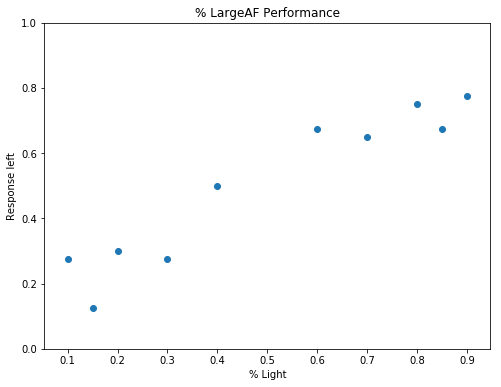

In [7]:
df_l = df[(df.run == '3')]
df_l =  df_l.dropna(subset=['correct_l']) # drop where color balance = 0.5
difficulties_l = sorted(df_l.color_balance.unique())
n_correct_l = []
n_trials_l = []
resp_light_l = []

for diff in difficulties_l:
    print(f'Diff: {diff}  \
    \t n_correct: {len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)])}  \
    \tn_trials: {len(df_l[df_l.color_balance == diff])} \
    \t% correct {100*len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)])/len(df_l[df_l.color_balance == diff]):.1f}')
    n_correct_l.append(len(df_l[(df_l.color_balance == diff) & (df_l.correct_l == 1)]))
    n_trials_l.append(len(df_l[df_l.color_balance == diff]))
#     print(f'% Light: {diff}, \t% Response Light {round(len(df[(df.color_balance == diff) & (df.response == "right")]) / len(df[df.color_balance == diff]) *100,1)}')
    resp_light_l.append(len(df_l[(df_l.color_balance == diff) & (df_l.response == "right")]) / len(df_l[df_l.color_balance == diff]))

proportions_l = np.array(n_correct_l) / np.array(n_trials_l)

largeAFx, largeAFy = abs(np.array(difficulties_l)-0.5), proportions_l
          
fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% LargeAF Performance')
axs.set_ylabel('Response left')
axs.set_ylim(0,1)
axs.set_xlabel('% Light')
axs.scatter(difficulties_l,resp_light_l)

### Plot small AF

,diff,n_trials,resp_light,n_correct,percent_correct
0,0.10,40.0,0.225,31.0,77.5
1,0.15,40.0,0.275,29.0,72.5
2,0.20,40.0,0.200,32.0,80.0
3,0.30,40.0,0.425,23.0,57.5
4,0.40,40.0,0.400,24.0,60.0
5,0.60,40.0,0.700,28.0,70.0
6,0.70,40.0,0.725,29.0,72.5
7,0.80,40.0,0.750,30.0,75.0
8,0.85,40.0,0.800,32.0,80.0
9,0.90,40.0,0.675,27.0,67.5


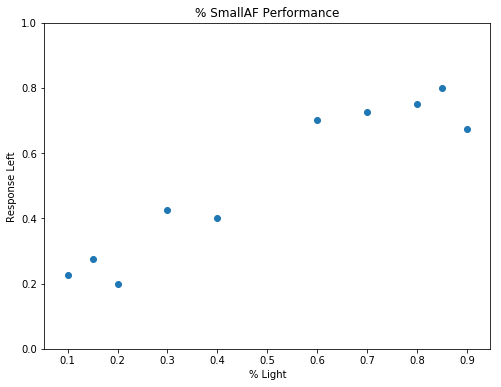

In [9]:
df_s = df[(df.run == '3')]
df_s =  df_s.dropna(subset=['correct_s']) # drop where fix color = 0
difficulties_s = sorted(df_s.fix_intensity.unique())
summary = pd.DataFrame([])
n_correct_s = []
n_trials_s = []
resp_light_s = []

for idx, diff in enumerate(difficulties_s):
    
    summary.loc[idx,'diff'] = diff
    summary.loc[idx,'n_trials'] = len(df_s[df_s.fix_intensity == diff])
    summary.loc[idx,'resp_light'] = len(df_s[(df_s.fix_intensity == diff) & (df_s.response == "right")]) / len(df_s[df_s.fix_intensity == diff])
    summary.loc[idx,'n_correct'] = len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])
    summary.loc[idx,'percent_correct'] = 100*len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])/len(df_s[df_s.fix_intensity == diff])
    summary.head()

    n_correct_s.append(len(df_s[(df_s.fix_intensity == diff) & (df_s.correct_s == 1)])) 
    n_trials_s.append(len(df_s[df_s.fix_intensity == diff]))
    resp_light_s.append(len(df_s[(df_s.fix_intensity == diff) & (df_s.response == "right")]) / len(df_s[df_s.fix_intensity == diff]))

proportions_s = np.array(n_correct_s) / np.array(n_trials_s)

smallAFx, smallAFy = abs(np.array(difficulties_s)), proportions_s

fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% SmallAF Performance')
axs.set_ylim(0,1)
axs.set_ylabel('Response Left')
axs.set_xlabel('% Light')
axs.scatter(difficulties_s,resp_light_s)

summary

## Plot difficulty v.s. proportion correct

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].set_title('SmallAF')
axs[0].set_ylabel('Proportion Correct')
axs[0].set_ylim(0,1)
axs[0].set_xlabel('% Light')
axs[0].scatter(smallAFx, smallAFy)

axs[1].set_title('LargeAF')
axs[1].set_ylabel('Proportion Correct')
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Distance from 50%')
axs[1].scatter(largeAFx, largeAFy)

# Fitting a sigmoid function to data

In [ ]:
nr = np.random.weibull(10,int(1e4))
plt.figure
plt.hist(nr,density=True,bins=50)
plt.show

p(x) = \frac{a} {\lambda}(\frac{x}{\lambda})^{a-1}e^{-(x/\lambda)^a},

0.46742138558643903 3.31517447514261


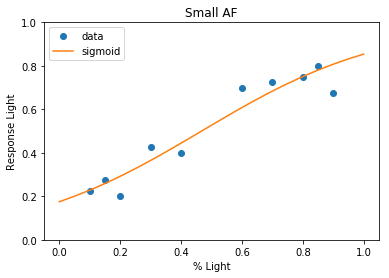

0.4946614528529604 3.267284210347026


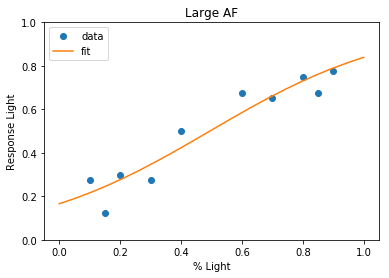

In [96]:
def sigmoid(x,x0,k):
    y = np.array(1 / (1 + np.exp(-k*(x-x0))))
    return y

def weibull(x,x0,k,g,l):
    y = g +(1-g -l)*sigmoid(x,k)
    return y

def inv_sigmoid(y,x0,k):
    return x0 - (np.log((1/y)-1)/k)

## SMALL AF ##
xdata = difficulties_s
ydata = resp_light_s

popt, pcov = curve_fit(sigmoid, xdata, ydata)

# val = (abs(0.5-inv_sigmoid(.2,*popt))+abs(0.5-inv_sigmoid(.2,*popt)))/2


print(*popt)

# print(f'20%: {inv_sigmoid(.2,*popt):.2f} \
#       \n80%: {inv_sigmoid(.8,*popt):.2f} \
#       \nYes/No Values: {0.5+val:.3f} , {0.5-val:.3f}')

x = np.linspace(0, 1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('Small AF')
plt.plot(x,y, label='sigmoid')
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()

## LARGE AF ##
xdata = difficulties_l
ydata = resp_light_l

popt, pcov = curve_fit(sigmoid, xdata, ydata)

# val = (abs(0.5-inv_sigmoid(.2,*popt))+abs(0.5-inv_sigmoid(.2,*popt)))/2

print(*popt)
# print(f'20%: {inv_sigmoid(.2,*popt):.2f} \
#       \n80%: {inv_sigmoid(.8,*popt):.2f} \
#       \nYes/No Values: {0.5+val:.3f} , {0.5-val:.3f}')

x = np.linspace(0, 1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('Large AF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('Response Light')
plt.xlabel('% Light')
plt.legend(loc='best')
plt.show()

# Testing BayesFit

Organize data into `[M X 3 ndarray]` where n is the number of stimulus intensities and the columns are: `[stimulus intensity, N trials correct, and N trials total]`.

In [ ]:
data_s = np.vstack((difficulties_s,n_correct_s, n_trials_s)).T

# metrics, options = bf.fitmodel(data_s, nafc = 2)

# Analysis of Attn PRF Detection Task

In [72]:
pd.read_table(f_names[0],keep_default_na=True).head(50)

,trial_nr,onset,event_type,phase,response,nr_frames,large_prop,small_prop,onset_abs,duration
0,0,0.097988,stim,0,NaN,5.0,0.5,0.5,6.295732,0.308069
1,0,0.000195,pulse,0,t,NaN,0.5,0.5,6.197939,NaN
2,0,0.406057,stim,1,NaN,12.0,0.5,0.5,6.603801,0.376873
3,0,0.782930,stim,2,NaN,7.0,0.5,0.5,6.980674,0.374500
4,0,1.157430,stim,3,NaN,14.0,0.5,0.5,7.355174,0.476073
5,0,1.500211,pulse,3,t,NaN,0.5,0.5,7.697954,NaN
6,1,1.633503,stim,0,NaN,8.0,0.5,0.5,7.831247,0.366040
7,1,1.999544,stim,1,NaN,19.0,0.5,0.5,8.197287,0.418079
8,1,2.417623,stim,2,NaN,7.0,0.9,0.5,8.615367,0.315516
9,1,2.733139,stim,3,NaN,15.0,0.9,0.5,8.930883,0.366013


In [65]:
wd = os.getcwd()
f_names = glob.glob(f"{wd}/logs/*/0_*.tsv")
all_logs = load_data(f_names)
if 'large_prop' in all_logs.columns:
    all_logs.rename(columns = {'large_prop':'color_balance','small_prop':'fix_intensity'}, inplace = True) 
all_logs.tail(25)

""


Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d' and the criterion (c). 

### Summary per run

In [61]:
Z = norm.ppf

def analyse_logs(all_logs, duration=1):
    """
    Analyses dataframe containing logs
    """

    runs = all_logs.task.unique() # sorted([int(i) for i in all_logs.run.unique()])
    psychophysics = pd.DataFrame(columns=['run', 'task', 'hits', 'misses', 'fas', 'correjs', 'dprime', 'criterion'])
    d_per_diff = pd.DataFrame(columns=['run', 'task','difficulty','hit_rate','fa_rate','d_prime','criterion'])
    large_AF_corr = []
    small_AF_corr = []


    for this_run in runs:
        this_run = this_run
        df = all_logs[all_logs['task'] == this_run]

        if df.task.iloc[0] == 'l':
            task = 'color_balance'
            baseline = 0.5
        elif df.task.iloc[0] == 's':
            task = 'fix_intensity'
            baseline = 0.5

        stim_df = df[df.event_type == 'stim']
        switch_loc = np.diff(stim_df[task], prepend=baseline) != 0
        switch_loc = stim_df[(switch_loc) & (stim_df[task] != baseline)].index  # drop values where color_balance is 0.5
        responses = df.loc[df.response == 'space']

        tp = sum([(abs(i - responses.onset) < duration).any() \
                  for i in stim_df.loc[switch_loc].end])  # true positives
        fn = len(switch_loc) - tp  # false negatives (missed switches)
        fp = len(responses) - tp  # false positives (responded with no switch)
        tn = len(stim_df) - len(switch_loc) - fn  # true negative

        # accuracy = (tp + tn) / (tp + fn + fp + tn)
        d, c = d_prime(tp, fn, fp, tn)

        difficulty = sorted(stim_df[task].unique())

        # add column for correctness for each stim
        stim_df['correct'] = np.nan
        hits = [(abs(i - responses.onset) < duration).any() \
                for i in stim_df.loc[switch_loc].end]
        misses = switch_loc[np.invert(hits)]
        hits = switch_loc[hits]

        # label hits and misses in stim_df
        stim_df.loc[hits, 'correct'] = stim_df.loc[hits, 'correct'].replace(np.nan, 1)
        stim_df.loc[misses, 'correct'] = stim_df.loc[misses, 'correct'].replace(np.nan, 0)

        # get closest stimulus corresponding to a response
        response_ids = [(abs(i - stim_df.end)).idxmin() for i in responses.onset]

        # find false alarm values
        fas = []
        for idx, j in enumerate(stim_df.loc[response_ids, 'correct'].isna().index):
            if (abs(j - stim_df[stim_df.correct == 1].index) <= 2).any() == False:
                fas.append(idx)
                stim_df.loc[response_ids[idx], 'correct'] = 0

        # [stim_df.loc[response_ids[i]] for i in fas]

        # set remaining nans as correct rejections
        cor_rej = stim_df[stim_df.loc[:, 'correct'].isna()].index
        stim_df.loc[cor_rej, 'correct'] = 1

        psychophysics = psychophysics.append({'run': this_run,
                                              'task': task,
                                              'hits': tp,
                                              'misses': len(switch_loc) - tp,
                                              'fas': fp,
                                              'correjs': tn,
                                              'dprime': d,
                                              'criterion': c, 
                                              'difficulties': difficulty}, ignore_index=True)

        # get proportion correct
        for i in difficulty:
            hit_rate = (sum(stim_df[stim_df[task] == i].correct) / len(stim_df[stim_df[task] == i]))
            if task == 'color_balance':
                if i != 0.5:
                    d_per_diff = d_per_diff.append({'run': this_run,
                                                    'task':task,
                                                    'difficulty':i,
                                                    'hit_rate': hit_rate,
                                                    'fa_rate': fp/(fp + tn),
                                                    'd_prime': Z(hit_rate) - Z(fp / (fp + tn)),
                                                    'criterion':-(Z(hit_rate) + Z(fp /(fp + tn)))/2},
                                                    ignore_index=True)
                    large_AF_corr.append([i, hit_rate])
            elif task == 'fix_intensity':
                if i != 0.5:
                    d_per_diff = d_per_diff.append({'run': this_run,
                                                    'task': task,
                                                    'difficulty': i,
                                                    'hit_rate': hit_rate,
                                                    'fa_rate': fp / (fp + tn), 
                                                    'd_prime': Z(hit_rate) - Z(fp / (fp + tn)),
                                                    'criterion':-(Z(hit_rate) + Z(fp /(fp + tn)))/2},
                                                    ignore_index=True)
                    small_AF_corr.append([i, hit_rate])

    return psychophysics, d_per_diff, large_AF_corr, small_AF_corr

In [62]:
psyc, d_primes, large_cor, small_cor = analyse_logs(all_logs)
psyc

,run,task,hits,misses,fas,correjs,dprime,criterion,difficulties
0,s,fix_intensity,63,11,9,364,3.017342,0.466424,"[0.075, 0.5, 0.925]"
1,l,color_balance,49,25,18,350,2.073857,0.618557,"[0.075, 0.5, 0.925]"


In [63]:
d_primes

,run,task,difficulty,hit_rate,fa_rate,d_prime,criterion
0,s,fix_intensity,0.075,0.837838,0.024129,2.960705,0.494742
1,s,fix_intensity,0.925,0.864865,0.024129,3.077535,0.436327
2,l,color_balance,0.075,0.675676,0.048913,2.111126,0.599923
3,l,color_balance,0.925,0.648649,0.048913,2.037160,0.636905


We can also calculate d' per difficulty level and plot this to see if two task difficulties are comparable. Unfortunately d' can go to infinity so many points are missing from the performance curves... and we're unsure if they're sigmoidal.

In [40]:
Z = norm.ppf
d_primes['d_prime']= Z(d_primes['hit_rate'])- Z(d_primes['fa_rate'])
d_primes['criterion'] = -(Z(d_primes['hit_rate']) + Z(d_primes['fa_rate'])) / 2
d_primes.head()

,run,task,difficulty,hit_rate,fa_rate,d_prime,criterion
0,3,fix_intensity,0.075,0.837838,0.021592,3.007528,0.518153
1,3,fix_intensity,0.925,0.824324,0.021592,2.953889,0.544973


In [42]:
large_AF = d_primes[d_primes['run'].astype(int) % 2 == 1]
small_AF = d_primes[d_primes['run'].astype(int) % 2 == 0]

Text(0, 0.5, 'Dprime')

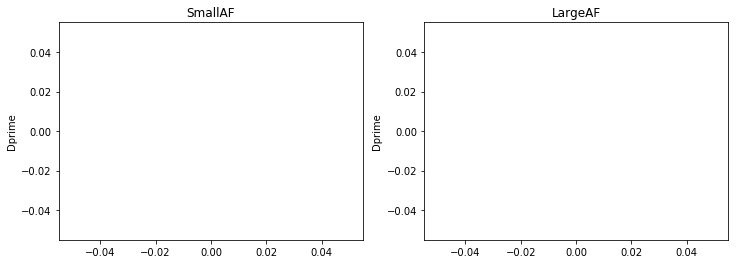

In [43]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.set_title('SmallAF')
ax1.scatter(abs(small_AF['difficulty']),small_AF['d_prime'])
ax1.set_ylabel('Dprime')

ax2.set_title('LargeAF')
ax2.scatter(abs(large_AF['difficulty']-0.5),large_AF['d_prime'],color='orange')
ax2.set_ylabel('Dprime')

We can also use proportion correct to create psychometric curves - although these are not traditional sigmoidal psychometric curves which are designed for 2 alternative forced-choice (2AFC) task. 

In [ ]:
largex, largey = (np.array([i[0] for i in large_cor]), 
                  np.array([i[1] for i in large_cor]))
smallx,smally = (np.array([i[0] for i in small_cor]), 
                np.array([i[1] for i in small_cor]))

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

ax1.set_title('LargeAF_Sigmoid')
ax1.scatter([abs(i[0]-0.5) for i in large_cor], [i[1] for i in large_cor])
ax1.set_ylabel('Proportion Correct')

ax2.set_title('LargeAF_Gauss')
ax2.scatter([i[0] for i in large_cor], [i[1] for i in large_cor])
ax2.set_ylabel('Proportion Correct')

ax3.set_title('SmallAF_Sigmoid')
ax3.set_ylim(0,1)
ax3.scatter([abs(i[0]-0) for i in small_cor], [i[1] for i in small_cor], color='orange')

ax4.set_title('SmallAF_Gauss')
ax4.set_ylim(0,1)
ax4.scatter([i[0] for i in small_cor], [i[1] for i in small_cor], color='orange')

# Modeling psychometric curve

In [ ]:
def psyc_stim_list(stim_range, n_stim, baseline):
    " Creates stim list for psychophysics task"
    stim_list = stim_range*int(n_stim/len(stim_range))
    [stim_list.append(i) for i in [baseline]*(n_stim-len(stim_list))]
    np.random.shuffle(stim_list)
    return stim_list

range = [0.1, 0.15, 0.2, 0.3, 0.4 ,0.5, 0.6, 0.7, 0.8, 0.85,0.9]
n = 225


stim = psyc_stim_list(range,n, 0.5)

for v in set(stim):
    c=0
    print(f'{v}: {sum([c +1 if v == stim[i] else c for i,j in enumerate(stim)])}')

In [ ]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,0.6,0.05)
    mu = 0.3
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

In [ ]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,0.6)
plt.ylim(0,1)
plt.show()